In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from pathlib import Path
import pandas as pd

In [3]:
#path = Path('/home/ubuntu/data/autopsy/milestone/no_preprocessing')

path = Path('/home/ubuntu/data/autopsy/2014_2018/no_preprocessing/reports/k-fold-suicide-homicide-accident')


In [4]:
df = pd.read_csv(path/'data_suicide_homicide_accident_k_1.csv')
df.head()

,label,text,is_valid
0,Accident,\n.MICRO.\nNONE\n.LOCATIONExtremities\n.INJURY...,False
1,Accident,\n.MICRO.\nHeart - no significant histopatholo...,False
2,Suicide,\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging...,False
3,Homicide,\n.MICRO.\nHEART: The sections of heart demons...,False
4,Homicide,\n.MICRO.\nHeart: No diagnostic abnormality. ...,False


In [5]:
df['text'][1]

'\n.MICRO.\nHeart - no significant histopathology\n\nLungs - congestion, no significant histopathology\n\nKidneys - no significant histopathology\n\nLiver - no significant histopathology\n\nHippocampus - no significant histopathology\n.LOCATIONExtremities\n.INJURYBlunt injury.\n.INJURYDESC.\nHealing abrasions measuring from 0.1 to 0.2 cm are on the posterior right hand.\n \nA 0.2 x 1.1 cm healing abrasion is in the left inguinal fold. \n\n\n\n.LOCATIONHead\n.INJURYBlunt injury.\n.INJURYDESC.\nA 0.9 x 0.6 cm abrasion is on the right side of the chin. '

In [6]:
bs=32

In [7]:

classes = ['Suicide','Homicide','Accident']

In [8]:
valid_df =  df.loc[df['is_valid']==True]

In [9]:
train_df = df.loc[df['is_valid']==False]

In [10]:
data_lm = TextLMDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, classes=classes,bs=bs)

In [11]:
data_lm.show_batch()

idx,text
0,\n \n \n xxup skeletal xxup elements \n \n xxmaj no palpable fractures . \n \n \n .locationtrunk \n .injuryblunt injury . \n xxup .injurydesc . \n xxup skin xxup and xxup deep xxup soft xxup tissues xxup of xxup the xxup chest xxup and xxup abdomen \n \n xxmaj extensive linear red and brown parchment - like abrasions are across the skin
1,"\n \n 8 . a 2.5 x 1 cm , irregular , red , patterned abrasion is immediately lateral to the left side of the mouth . \n \n 9 . a 7.5 cm , full - thickness , oblique laceration extends across the anterior chin with exposure of the underlying bone . \n \n 10 . a 3 x 1.5 cm , irregular , red abrasion"
2,"u , v ) \n \n xxmaj entrance ( u ) : \n \n xxmaj on the medial aspect of the right wrist , 33 cm distal to the right elbow and 3 cm left of the anterior arm midline , is an entrance gunshot wound ( u ) consisting of a 0.6 x 0.6 cm round defect with a 0.1 cm pink circumferential marginal abrasion . xxmaj"
3,"a 3.3 cm long , horizontally oriented , stab wound with sharp angles at 3 and 9 oâclock . a 0.2 x 0.1 cm , red abrasion is on the skin just below the 3 o'clock angle . \n \n \n xxmaj path \n \n xxmaj the hemorrhagic wound track sequentially perforates the skin , subcutaneous tissue and muscle of the left chest , the intercostal muscles between"
4,"cavity and approximately 135 ml of blood within the left chest cavity . \n \n .locationextremities \n .injurymultiple injuries . \n xxup .injurydesc . \n xxmaj the dorsal right hand shows scattered irregular incised wounds , each measuring up to 1 / 4 inch . xxmaj on the anterior left knee are irregular red abrasions , covering an area of approximately 6 x 2 inches ."


In [12]:
learn = language_model_learner(data_lm, arch=AWD_LSTM)

In [13]:
learn.freeze()

In [14]:
#do some gradual unfreezing, so we don't lose the pretrained info
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,2.455612,2.079415,0.538264,01:02
2,2.280120,1.960785,0.556618,01:02


In [15]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.958534,1.782304,0.585145,01:04


In [16]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.836524,1.695254,0.600169,01:08


In [17]:
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.789840,1.666396,0.605681,01:12
2,1.651565,1.618222,0.614202,01:12
3,1.649707,1.557551,0.626360,01:12
4,1.531272,1.524341,0.633176,01:13
5,1.512389,1.493408,0.639075,01:12
6,1.475628,1.474914,0.642445,01:12
7,1.435766,1.466471,0.644656,01:13
8,1.442963,1.465426,0.644957,01:12


In [18]:
learn.save_encoder('fine_tuned_enc_no_pretrain2')

In [19]:
data_clas = TextClasDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, vocab=data_lm.train_ds.vocab, bs=bs, classes=classes)

In [20]:
data_clas.show_batch()

text,target
"xxbos \n xxup .micro . \n xxmaj heart - no significant histopathology \n \n xxmaj lungs - patchy extravasation of red blood cells into the intra - alveolar space \n \n xxmaj kidneys - no significant histopathology \n \n xxmaj liver - no significant histopathology \n \n xxmaj hippocampus - no significant histopathology \n \n xxmaj xxunk - vaginal , anal , and",Homicide
xxbos \n xxup .micro . \n xxmaj heart : xxmaj some of the cardiomyocyte nuclei are slightly enlarged . \n \n xxmaj lungs : xxmaj partially atelectatic with rare intra - alveolar macrophages . \n \n xxmaj liver : xxmaj mild lymphoplasmacytic inflammation confined to portal tracts . \n \n xxmaj kidney : xxmaj partially autolyzed with no significant histopathologic abnormalities . \n \n,Homicide
xxbos \n xxup .micro . \n xxup heart : xxmaj no significant histopathologic diagnosis . \n \n xxup lungs : xxmaj there is patchy blood within alveolar spaces . \n \n xxup liver : xxmaj there is diffuse autolysis . xxmaj inflammation is periportal and consists predominantly of lymphocytes and some neutrophils . \n \n xxup kidney : xxmaj tubular autolysis and no significant histopathologic,Homicide
"xxbos \n xxup .micro . \n xxmaj heart : xxmaj sections of the heart are partially autolyzed and show no significant histopathologic change . \n \n xxmaj lungs : xxmaj sections of lung are partially autolyzed and show focal carbon pigment and peribronchial chronic inflammation . \n \n xxmaj liver : a section of liver is autolyzed but shows mild , predominantly lymphocytic inflammation of the",Homicide
"xxbos \n xxup .micro . \n xxup none \n .locationhead \n .injurysharp injury . \n xxup .injurydesc . \n xxup stab xxup wound xxup of xxup left xxup temple ( y ) \n \n xxmaj on the left temple , 10 cm below the top of the head , 12.5 cm left of the anterior midline ( measured around the head ) and",Homicide


In [21]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc_no_pretrain2')
learn.freeze()

In [22]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.496304,0.530096,0.858073,01:03


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.384643,0.374816,0.892578,01:13


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.343935,0.347136,0.908203,01:29


In [25]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(3e-4,3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.313308,0.336531,0.908203,02:05
2,0.317150,0.335088,0.908854,01:58
3,0.304244,0.312778,0.911458,01:48
4,0.275273,0.301537,0.914062,01:49
5,0.291528,0.339774,0.910156,01:49
6,0.235377,0.327983,0.904297,02:05
7,0.211315,0.315582,0.916667,01:57
8,0.217343,0.364763,0.917969,01:48
9,0.174435,0.390106,0.915365,01:48
10,0.135170,0.406347,0.917318,01:56


In [26]:
from fastai.vision import *

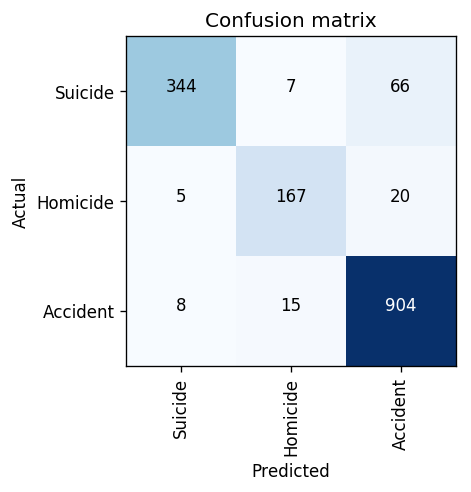

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

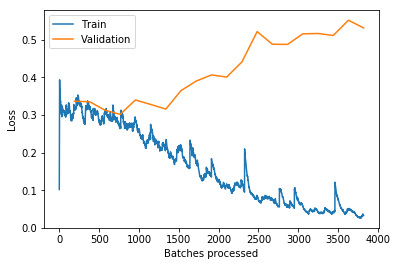

In [28]:
learn.recorder.plot_losses()

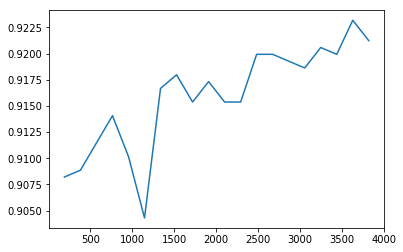

In [29]:
learn.recorder.plot_metrics()

In [30]:
def intrinsic_attention_modified_old(self, text:str, class_id:int=None):
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        self.model.train()
        self.model.zero_grad()
        self.model.reset()
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        self.model.zero_grad()
        self.model.reset()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn
    
def intrinsic_attention_modified(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)                
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max() 
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

def eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): eval_dropouts(module)

TextClassificationInterpretation.intrinsic_attention = intrinsic_attention_modified
ci = TextClassificationInterpretation.from_learner(learn)

In [31]:
import matplotlib.cm as cm

In [32]:
def interpret_result(row_index):
    example = df['text'][row_index]
    label = df['label'][row_index]
    print('True Label:',label)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    print('\nPred Label:',prediction_class)
    print('\nClass Probabilities:',prediction_probs)
    
    print('\n***Raw Text***')
    print(example)
    
    print('\n***Intrinsic Attention***')
    
    ci.show_intrinsic_attention(example,  cmap=cm.Reds)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    
    

In [33]:
interpret_result(16)

True Label: Accident

Pred Label: Accident

Class Probabilities: tensor([1.8629e-04, 9.5244e-06, 9.9980e-01])

***Raw Text***

.MICRO.
NONE
.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
Left leg shorter than Right leg. Left leg bent at knee and foot rotated outward.

***Intrinsic Attention***


In [34]:
interpret_result(20)

True Label: Accident

Pred Label: Accident

Class Probabilities: tensor([5.6940e-07, 2.7951e-06, 1.0000e+00])

***Raw Text***

.MICRO.
Heart: Negative

Lungs: Pulmonary edema

Liver: Mild steatosis

Kidney: Mild arteriolonephrosclerosis

Brain: Negative
.LOCATIONExtremity
.INJURYIllicit substance use.
.INJURYDESC.
Acute injection sites left antecubital fossa

.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
Avulsed central incisor

***Intrinsic Attention***


In [35]:
interpret_result(50)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9998e-01, 4.9867e-06, 1.6165e-05])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead and neck
.INJURYHanging.
.INJURYDESC.
PRESENCE OF A LIGATURE: Not present 

DESCRIPTION OF THE LIGATURE:  N/A

LIGATURE FURROW: 

COMPLETELY OR PARTIALLY CIRCUMFERENTIAL:  Complete (primary) with incomplete left lateral takeoff 

COLOR:  Tan with purple margins 

ABRASION:  No pattern

WIDTH:  Up to 1.2 cm

LOWEST POINT OF LIGATURE FURROW:  Immediately above laryngeal prominence

HIGHEST POINT OF LIGATURE FURROW:  18 cm top of head (primary) and 14 cm top of head (secondary); 6 cm below inferior attachment of each ear 

OTHER INJURIES:  Blue ecchymosis left medial lower eyelid; purple ecchymoses up to 5 x 1 cm on left neck superior and inferior to furrow, oriented parallel to furrow

PETECHIAL HEMORRHAGES:  Prominent periorbital cutaneous petechiae; fine bulbar and palpebral petechiae 

***Intrinsic Attention***


In [36]:
interpret_result(69)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([1.0000e+00, 4.2247e-10, 3.0587e-08])

***Raw Text***

.MICRO.
NONE
.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
A 0.5 cm wide, woven blue rope ligature encircles the neck with a knot behind the left ear. The loop around the neck is 32 cm in length and the tails from the knot are 4 and 82 cm  in length. 

A 44 cm long by 0.5 to 1 cm wide, abraded, brown ligature furrow completely encircles the neck. The furrow cross the anterior midline at its lowest point, above the thyroid cartilage and 23 cm below the top of the head, and cants upwards towards both ears. The furrow passes at 22 cm below the top of the head below the right ear and wraps around the posterior neck. The ligature crosses itself and disappears into the hairline behind the left ear at a point 14 cm below the top of the head.

There are no facial, conjunctival, or oral petechiae, although the face and scalp are congested. There are tardieu spots on the lowe

In [37]:
interpret_result(7663)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([2.5845e-03, 9.9715e-01, 2.6638e-04])

***Raw Text***

.MICRO.
HEART - No significant histopathology identified.

LUNGS - Focal areas of parenchymal collapse and septal congestion; no significant histopathology is identified.

LIVER - Very mild macrovesicular steatosis and focal peri-portal chronic lymphocytic inflammation without associated fibrosis.  The background liver parenchyma shows sinusoidal congestion.

KIDNEY - No significant histopathology identified.
.LOCATIONBack
.INJURYBlunt injury.
.INJURYDESC.
A dried brown abrasion is on the left mid-back, measuring 4.0 x 2.0 cm.

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
Multiple scattered, red linear abrasions are on the right upper arm and forearm, the largest measuring 7.0 x 0.1 cm.

A purple contusion is on right posterolateral forearm measuring 2.3 x 3.0 cm.

.LOCATIONExtremities
.INJURYBlunt injury.
.INJURYDESC.
Multiple small (0.1 - 0.2 cm) red 

In [38]:
interpret_result(7603)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([7.9123e-04, 9.9900e-01, 2.1058e-04])

***Raw Text***

.MICRO.
Heart-No histopathologic abnormalities. 

Lungs-Parenchymal congestion. 

Kidneys-Autolytic changes and congestion. 

Liver-Central venous congestion. 

Brain-Hippocampus with no histopathologic abnormalities. 
.LOCATIONBack
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF the back

Entrance:

On the mid back, 47.0 cm below the top of the head, 2.0 cm right posterior midline, and 111.0 cm superior to the heel, is an entrance gunshot wound consisting of a 0.6 x 0.6  cm round defect with a 1.4 x 1.2 cm wide circumferential pink marginal abrasion which is widest at 2 oâclock position.  Soot, unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Path:

The hemorrhagic wound track sequentially perforates the skin and soft tissue of the mid back, the 12th thoracic vertebral body, the inferior vena cava,

In [39]:
valid = df.loc[df['is_valid']==True]

In [40]:
valid

,label,text,is_valid
16,Accident,\n.MICRO.\nNONE\n.LOCATIONExtremity\n.INJURYBl...,True
20,Accident,\n.MICRO.\nHeart: Negative\n\nLungs: Pulmonary...,True
22,Accident,\n.MICRO.\nHeart: Sections of the heart show i...,True
30,Accident,"\n.MICRO.\nBRAIN: No significant, histopatholo...",True
32,Accident,\n.MICRO.\nLIVER: Sinusoidal congestion with ...,True
40,Accident,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYBlunt i...,True
47,Accident,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYBlunt i...,True
50,Suicide,\n.MICRO.\nNONE\n.LOCATIONHead and neck\n.INJU...,True
53,Accident,"\n.MICRO.\nBRAIN: No significant, histopatholo...",True
60,Accident,\n.MICRO.\nHeart: Negative\n\nLungs: Negative\...,True


In [41]:
'''for i in range(0,3040):
    example = df['text'][i]
    label = df['label'][i]
    val = df['is_valid'][i]
    prediction_class = learn.predict(example)[0]
    if str(label) != str(prediction_class):
        print(i, label, prediction_class, val)
'''

"for i in range(0,3040):\n    example = df['text'][i]\n    label = df['label'][i]\n    val = df['is_valid'][i]\n    prediction_class = learn.predict(example)[0]\n    if str(label) != str(prediction_class):\n        print(i, label, prediction_class, val)\n"